# Hand localization model training with YOLOv5
In this notebook we will generate a model for the hand recognition and localization task using YOLOv5 and train it.
The procedure is divided into steps:
1) Manage dependencies and main YOLOv5 files
2) Download and extract dataset
3) Convert annotation of dataset into YOLOv5 format
4) Check on from some random samples that conversion is good
5) Last steps
6) Train the model

### 1) Download YOLO and import necessary dependencies

In [1]:
import os, shutil
if not os.path.isdir('yolov5'):
    os.system('git clone https://github.com/ultralytics/yolov5')

# install and import yolov5 dependencies
!pip install -qr yolov5/requirements.txt
import torch, random
import numpy as np
from IPython.display import Image, clear_output

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

# import dependencies to extract dataset
import requests, tarfile

# import & install dependencies needed to convert dataset label format to yolov5
!apt-get install libmagic-dev
!pip install python-magic
import magic, re, scipy.io

# import libs to verify conversion in step 4
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# mount drive
from google.colab import drive
drive.mount('/content/drive')

Setup complete. Using torch 1.11.0+cu102 (Tesla T4)
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libmagic-dev is already the newest version (1:5.32-2ubuntu0.4).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2) Download and extract dataset
We will now download(if it has not been already downloaded) the Oxford Hand Dataset which contains some images with hands and some Matlab files which will contain a 4 point bounding box around each hand in each image(a file for each image).<br>
After that we will extract the dataset(only if it has not been already extracted). All three subsets will be extracted, namely: 
- Training set
- Validation set
- Test set

In [2]:
# check if dataset has been downloaded: download it otherwise
validation_ds_tar_path = "hand_dataset.tar.gz"
if not(os.path.exists(validation_ds_tar_path)):
    response = requests.get("https://www.robots.ox.ac.uk/~vgg/data/hands/downloads/hand_dataset.tar.gz")
    open("hand_dataset.tar.gz", "wb").write(response.content)


# extract only useful data(if not already present)
datasets_extr = ["hand_dataset/training_dataset/training_data/",
                 "hand_dataset/validation_dataset/validation_data/",
                 "hand_dataset/test_dataset/test_data/"]

with tarfile.open('hand_dataset.tar.gz') as archive:
    for file_name in archive.getnames():
        if any(s in file_name for s in datasets_extr) and not ("._.DS_Store" in file_name or ".DS_Store" in file_name):
            if not os.path.exists(os.path.join(".", file_name)):
                archive.extract(file_name, path=".")

### 3) Convert annotation of dataset into YOLOv5 format
Now it's time to convert the Matlab annotations into the data format that YOLO uses. To do so we use scipy to read the _.mat_ files and get the bounding box coordinates.<br>
In the Oxford Hand Dataset each hand bounding box is represented by four points that form a polygon which will be considered the bounding box of a hand occurrence inside a picture.<br>
In each annotation file there might by more than just one set of four points, depending on the number of hands present in the corresponding image.<br>
[MAYBE ADD SOME IMAGES?]<br>
<br>
We want to convert this annotations arrangement into a _.txt_ file for each _.mat_ file, which will contain, instead of the four bounding box vertices, the bounding box **center**, its **height** and **width**.<br>
These text files will be saved in a directory which will be called "*labels*" right next to the pictures and Matlab annotations folders.


In [3]:
def get_width_height_from_img_path(file_full_path : str) -> np.ndarray:
    t = magic.from_file(filename=file_full_path)
    size_str = re.search("(\d+)x(\d+)", t[106:120]).groups() # format is WxH
    size = np.array(object=(float(size_str[0]), float(size_str[1])), dtype=float)
    return size

def extract_annotation(annotations_full_path : str) -> list: 
    # load mat file and get correct data
    annotation = scipy.io.loadmat(annotations_full_path)
    boxes = annotation.get("boxes")

    # convert to ndarray
    hand_boxes_accurate : list[np.ndarray] = []
    for i in range(boxes.shape[1]):
        pts = np.zeros(shape=(4,2), dtype=int)
        for j in range(4):
            pts[j,0] = round(boxes[0,i][0,0][j][0,1])
            pts[j,1] = round(boxes[0,i][0,0][j][0,0])
        hand_boxes_accurate.append(pts)
        del(pts)
    
    return hand_boxes_accurate

def convert_box_to_yolov5_std_str(img_size : np.ndarray, hand_box : np.ndarray) -> str:
    # calculate relaxed bbox coordinates
    top_left_pt = np.zeros(shape=2, dtype=float)
    bottom_right_pt = np.zeros(shape=2, dtype=float)
    np.amin(hand_box, axis=0, out=top_left_pt)
    np.amax(hand_box, axis=0, out=bottom_right_pt)

    # compute bbox size
    bbox_size = bottom_right_pt - top_left_pt

    # compute bbox center
    center = top_left_pt + bbox_size/2.

    # normalization (image width and height considered as 1)
    bbox_size = bbox_size / img_size
    center = center / img_size

    # here the initial zero represent the class of the object, since all are hands it is always the same
    return "0 {:.6f} {:.6f} {:.6f} {:.6f}".format(center[0],center[1],bbox_size[0],bbox_size[1])

def save_annotations_to_txt(img_size : np.ndarray, bad_annotation : list, new_annotation_path : str):
    txt = open(new_annotation_path, "w")

    final_annotation : str = ""
    for annot in bad_annotation:
        final_annotation += convert_box_to_yolov5_std_str(img_size=img_size, hand_box=annot) + "\n"
    
    txt.write(final_annotation[:len(final_annotation)-2])   # do not write last \n
    
    txt.close()


for dir_path in datasets_extr:

    if not os.path.exists(dir_path+"labels"):  # create dir containing new labels
        os.mkdir(path=dir_path+"labels")
    
    for file_name in os.listdir(path=dir_path+"images/"):

        cur_img_full_path = dir_path + "images/" + file_name
        cur_size = get_width_height_from_img_path(cur_img_full_path) # get width & height of current image
        #print(curr_size)

        cur_annot_full_path = dir_path + "annotations/" + file_name[:len(file_name)-4] + ".mat"
        cur_annotation = extract_annotation(cur_annot_full_path)
        #print(cur_annotation[0])

        new_annot_full_path = dir_path + "labels/" + file_name[:len(file_name)-4] + ".txt"
        save_annotations_to_txt(img_size=cur_size, bad_annotation=cur_annotation, new_annotation_path=new_annot_full_path)

### 4) Check conversions
Now to check if the conversion result is correct by visualizing random samples for each subset of the dataset and drawing the converted bounding box(es) onto it.<br>
We also have shown original bounding boxes to see the difference between those and the converted ones

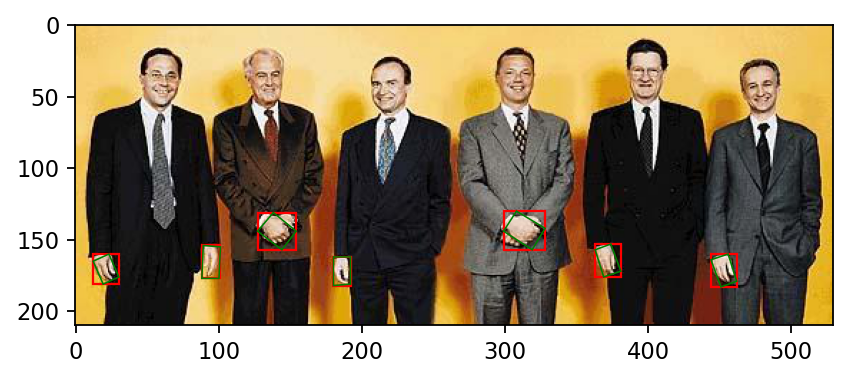

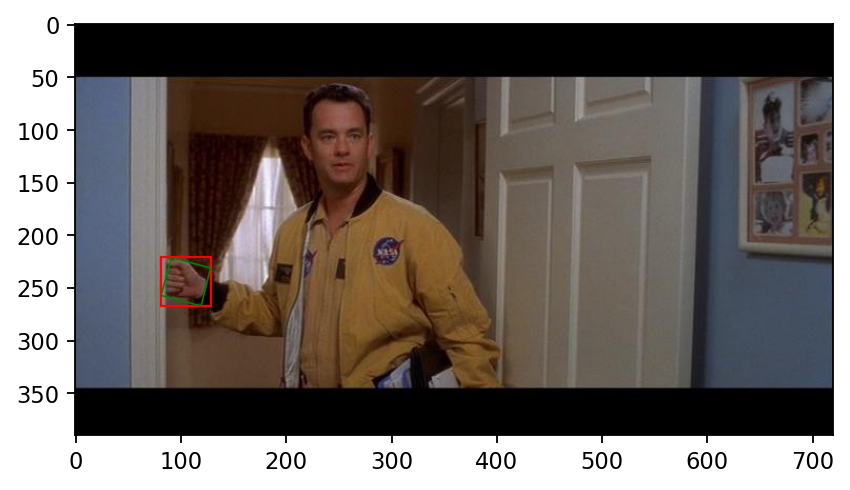

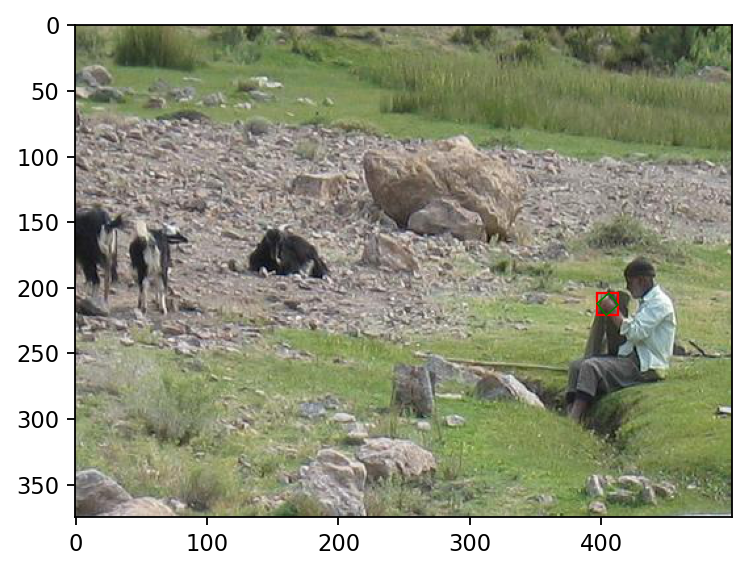

In [4]:
for dir_path in datasets_extr:
    # randomly select an image
    rnd_img = random.choice(os.listdir(dir_path + "images/"))

    # open the image
    img = Image.open(dir_path + "images/" + rnd_img)

    # create figure and axes
    fig, ax = plt.subplots(dpi=163)

    # display the image
    ax.imshow(img)

    #covert line string into ndarray
    bbox_yolo_coords = []
    with open(dir_path + "labels/" + rnd_img[:len(rnd_img)-4] + ".txt") as txt:

        lines = txt.read().splitlines()
        for line in lines:
            bbox_yolo_coords.append(np.fromstring(line[1:], dtype=float, sep=' ', count=4))
    
    # de-normalize coordinates and draw bbox onto img
    for box in bbox_yolo_coords:
        box[0] *= float(img.width)
        box[2] *= float(img.width)
        box[1] *= float(img.height)
        box[3] *= float(img.height)
        ax.add_patch(patches.Rectangle((box[0]-box[2]/2., box[1]-box[3]/2.), width=box[2], height=box[3], linewidth=1, edgecolor='r', facecolor='none'))
    
    # now draw original bbox in green
    mat_coords = extract_annotation(annotations_full_path=dir_path + "annotations/" + rnd_img[:len(rnd_img)-4] + ".mat")
    for mat_bbox in mat_coords:
        ax.add_patch(patches.Polygon(mat_bbox, linewidth=0.7, edgecolor='g', facecolor='none'))

    plt.show()

### 5) Last steps before training
Now we need to setup last things to train the yolo model. We will follow the following steps:
- Copy images and labels into a directory system suitable to yolov5

In [5]:
dirs = ["./images/", "./labels/", "./images/train/", "./labels/train/", "./images/val/", "./labels/val/", "./images/test/", "./labels/test/"]
for dir_ in dirs:
    if not os.path.exists(dir_):
        os.mkdir(dir_)

# move dataset into directories "images" and "labels" which are located in same position as the notebook
subsets = ["train/", "val/", "test/"]
for i in range(3):
    for img_name in os.listdir(datasets_extr[i] + "images/"):
        old_img_path = datasets_extr[i] + "images/" + img_name
        old_lbl_path = datasets_extr[i] + "labels/" + img_name[:len(img_name)-3] + "txt"
        new_img_path = dirs[0] + subsets[i] + img_name
        new_lbl_path = dirs[1] + subsets[i] + img_name[:len(img_name)-3] + "txt"

        # copy img if it's not already there
        if not os.path.exists(new_img_path):
            shutil.copyfile(old_img_path, new_img_path)
        if not os.path.exists(new_lbl_path):
            shutil.copyfile(old_lbl_path, new_lbl_path)

- Create dataset location _yaml_ file (In our case move the premade one into the right directory)

In [6]:
# move data.yaml
new_data_yaml = "./yolov5/data/hand_data.yaml"
if os.path.exists(new_data_yaml):
    os.remove(new_data_yaml)
shutil.copyfile("./drive/MyDrive/CV_proj_data/hand_data.yaml", new_data_yaml)


print("------------------ hand_data.yaml ---------------------")
with open(new_data_yaml) as f:
    lines = f.read().splitlines()
    for line in lines:
        print("\t" + line)
print("-------------------------------------------------------")

------------------ hand_data.yaml ---------------------
	train: ../images/train/ 
	val:  ../images/val/
	test: ../images/test/
	
	# number of classes
	nc: 1
	
	# class names
	names: ["hand"]
-------------------------------------------------------


- Setup hyperparameters file, which will contain all usual parameters used when training a neural network (Same as before, we will move the premade one into the right directory)<br>
  We are just going to use the default one

In [7]:
hyperparams_yaml = "./yolov5/data/hyps/hyp.scratch-med.yaml"
print("-------------------------------------------------- hyp.scratch-med.yaml -----------------------------------------------------")
with open(hyperparams_yaml) as f:
    lines = f.read().splitlines()
    for line in lines:
        print("\t" + line)
print("-----------------------------------------------------------------------------------------------------------------------------")

-------------------------------------------------- hyp.scratch-med.yaml -----------------------------------------------------
	# YOLOv5 🚀 by Ultralytics, GPL-3.0 license
	# Hyperparameters for medium-augmentation COCO training from scratch
	# python train.py --batch 32 --cfg yolov5m6.yaml --weights '' --data coco.yaml --img 1280 --epochs 300
	# See tutorials for hyperparameter evolution https://github.com/ultralytics/yolov5#tutorials
	
	lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)
	lrf: 0.1  # final OneCycleLR learning rate (lr0 * lrf)
	momentum: 0.937  # SGD momentum/Adam beta1
	weight_decay: 0.0005  # optimizer weight decay 5e-4
	warmup_epochs: 3.0  # warmup epochs (fractions ok)
	warmup_momentum: 0.8  # warmup initial momentum
	warmup_bias_lr: 0.1  # warmup initial bias lr
	box: 0.05  # box loss gain
	cls: 0.3  # cls loss gain
	cls_pw: 1.0  # cls BCELoss positive_weight
	obj: 0.7  # obj loss gain (scale with pixels)
	obj_pw: 1.0  # obj BCELoss positive_weight
	iou_t: 0.2

- A custom network architecture can also be specified by specifing with _-cfg_ argument the custom network architecture file.<br>
  Below there is and example taken from a default yolo network architecture

In [8]:
net_architecture_yaml = "./yolov5/models/yolov5l.yaml"
print("------------------------------------------------------ yolov5m.yaml --------------------------------------------------------")
with open(net_architecture_yaml) as f:
    lines = f.read().splitlines()
    for line in lines:
        print("\t" + line)
print("-----------------------------------------------------------------------------------------------------------------------------")

------------------------------------------------------ yolov5m.yaml --------------------------------------------------------
	# YOLOv5 🚀 by Ultralytics, GPL-3.0 license
	
	# Parameters
	nc: 80  # number of classes
	depth_multiple: 1.0  # model depth multiple
	width_multiple: 1.0  # layer channel multiple
	anchors:
	  - [10,13, 16,30, 33,23]  # P3/8
	  - [30,61, 62,45, 59,119]  # P4/16
	  - [116,90, 156,198, 373,326]  # P5/32
	
	# YOLOv5 v6.0 backbone
	backbone:
	  # [from, number, module, args]
	  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
	   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
	   [-1, 3, C3, [128]],
	   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
	   [-1, 6, C3, [256]],
	   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
	   [-1, 9, C3, [512]],
	   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
	   [-1, 3, C3, [1024]],
	   [-1, 1, SPPF, [1024, 5]],  # 9
	  ]
	
	# YOLOv5 v6.0 head
	head:
	  [[-1, 1, Conv, [512, 1, 1]],
	   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
	   [[-1, 6], 1, Concat, [1]],  # cat b

### 6) Training the yolo model

In [9]:
# 313 could be a good batch size (1,13,313,4069)
#!cd yolov5
#!python yolov5/train.py --img 512 --cfg yolov5l.yaml --hyp hyp.scratch-med.yaml --batch 50 --epochs 50 --data hand_data.yaml --weights ' ' --workers 2 --name yolo_hand_localization

#!zip -r ./training_result_runs.zip ./yolov5/runs

#from google.colab import files
#files.download("./training_result_runs.zip")

###6a) Train the yolo model saving the result to google drive every 20 epoch

In [ ]:
def backup_after_iter(epoch : int):
    # remove old backup if any
    for filename in os.listdir("./drive/MyDrive/CV_proj_data/weights/bak/"):
        os.remove("./drive/MyDrive/CV_proj_data/weights/bak/" + filename)
    
    # backup previous weights
    for filename in os.listdir("./drive/MyDrive/CV_proj_data/weights/"):
        if os.path.isfile(os.path.join("./drive/MyDrive/CV_proj_data/weights/", filename)):
            shutil.copy("./drive/MyDrive/CV_proj_data/weights/" + filename, "./drive/MyDrive/CV_proj_data/weights/bak/" + filename)
    
    # remove previous weights(do not remove "bak" folder)
    for filename in os.listdir("./drive/MyDrive/CV_proj_data/weights/"):
        if os.path.isfile(os.path.join("./drive/MyDrive/CV_proj_data/weights/", filename)):
            os.remove(os.path.join("./drive/MyDrive/CV_proj_data/weights/", filename))

    # save current weights and epoch to drive
    shutil.copy("./yolov5/runs/train/hand_loc/weights/best.pt", "./drive/MyDrive/CV_proj_data/weights/best.pt")
    shutil.copy("./yolov5/runs/train/hand_loc/weights/last.pt", "./drive/MyDrive/CV_proj_data/weights/last.pt")

    # generate new file with the number of epochs and batch size
    with open("./drive/MyDrive/CV_proj_data/weights/epoch_" + str(epoch) + ".txt", 'w') as f:
        f.write("Batch size = " + str(batch_size))
    
    # remove previous weights if any
    if os.path.exists("./last.pt"):
        os.remove("./last.pt")

    # copy latest weights into "home" directory
    shutil.copy("./yolov5/runs/train/hand_loc/weights/last.pt", "./last.pt")

    # remove the old training directory
    shutil.rmtree("./yolov5/runs")

# yolov5 model is set to medium(small didn't look very good on 100 epoch)

max_iterations = 10 # it's value is the number of epoch * 20 after which the training stops
batch_size = 30 # changing this won't affect actual batch size

# first iteration
if os.path.exists("./drive/MyDrive/CV_proj_data/weights/last.pt"):
    shutil.copy("./drive/MyDrive/CV_proj_data/weights/last.pt", "./last.pt")

    # run first iteration of yolo on existing weights
    !python yolov5/train.py --img 512 --cfg yolov5m.yaml --hyp hyp.scratch-med.yaml --batch 40 --epochs 30 --data hand_data.yaml --weights ./last.pt --workers 2 --name hand_loc

else:
    # run first iteration of yolov5 trainig on empty weights
    !python yolov5/train.py --img 512 --cfg yolov5m.yaml --hyp hyp.scratch-med.yaml --batch 40 --epochs 30 --data hand_data.yaml --weights ' ' --workers 2 --name hand_loc

# at the end place of first iteration do backup
backup_after_iter(20)

for i in range(1, max_iterations, 1):
    
    # run yolov5 training
    !python yolov5/train.py --img 512 --cfg yolov5m.yaml --hyp hyp.scratch-med.yaml --batch 40 --epochs 30 --data hand_data.yaml --weights ./last.pt --workers 2 --name hand_loc

    # save weights after training iteration of 20 epoch
    backup_after_iter(i*20)

train: weights=./last.pt, cfg=yolov5m.yaml, data=hand_data.yaml, hyp=hyp.scratch-med.yaml, epochs=30, batch_size=40, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=2, project=yolov5/runs/train, name=hand_loc, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-297-g72a81e7 Python-3.7.13 torch-1.11.0+cu102 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.3, cls_pw=1.0, obj=0.7, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0

In [ ]:
#shutil.copy("./drive/MyDrive/CV_proj_data/weights/bak/best.pt", "./drive/MyDrive/CV_proj_data/weights/best.pt")
#shutil.copy("./drive/MyDrive/CV_proj_data/weights/bak/last.pt", "./drive/MyDrive/CV_proj_data/weights/last.pt")

In [ ]:
#shutil.rmtree("./yolov5/runs")